# HW1
本次作业使用策略迭代的方法来实现书中的例3.5. 使用的语言是Python3，主要使用的模块是NumPy，作业在CPU上完成.

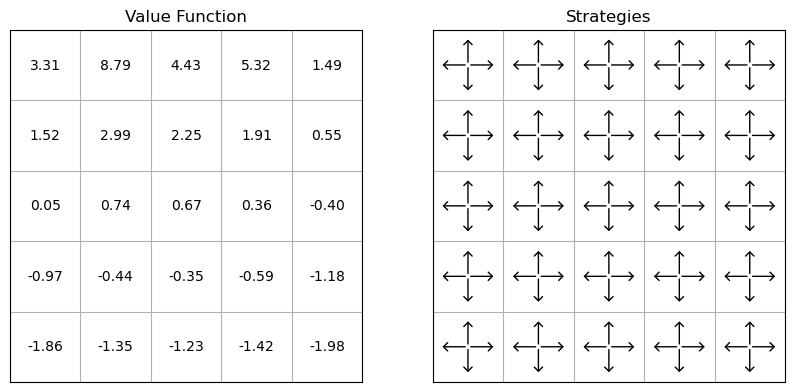

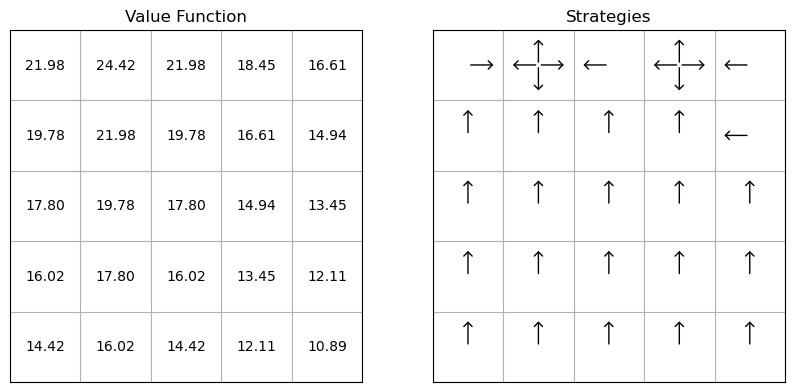

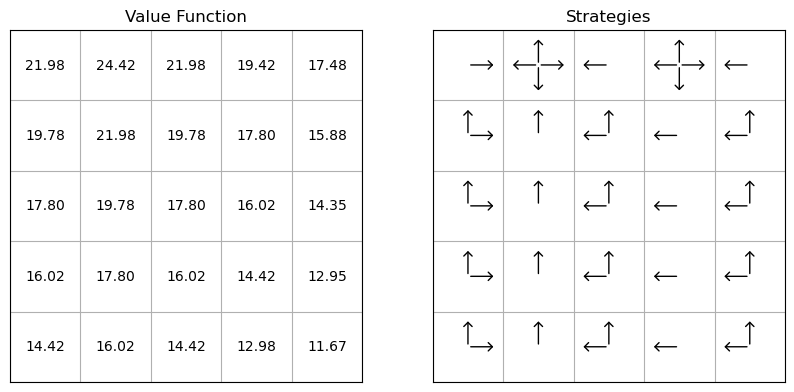

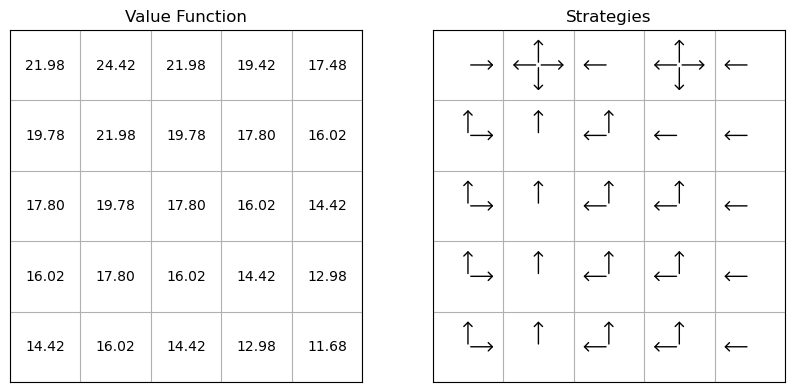

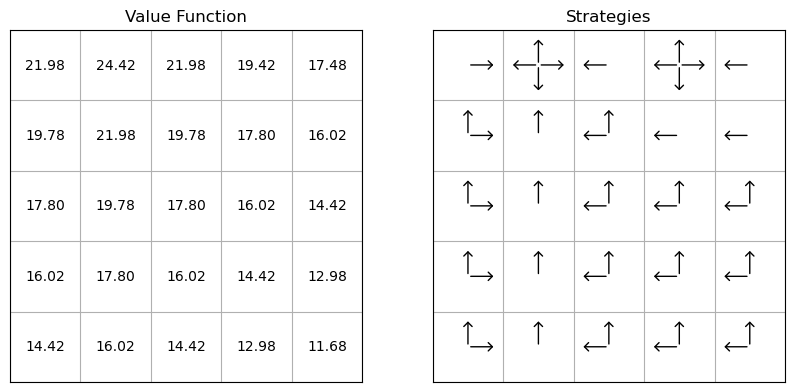

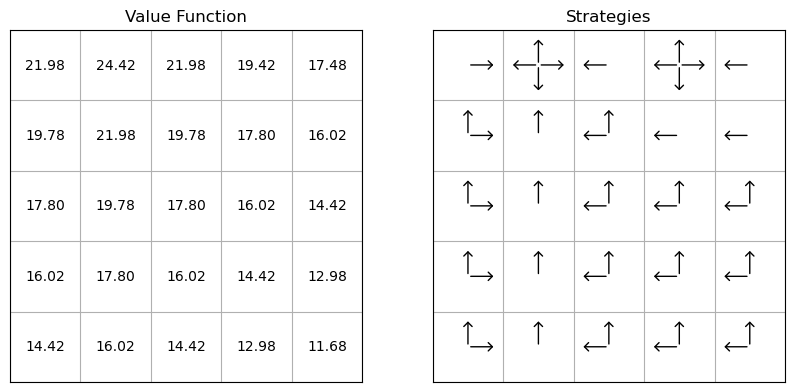

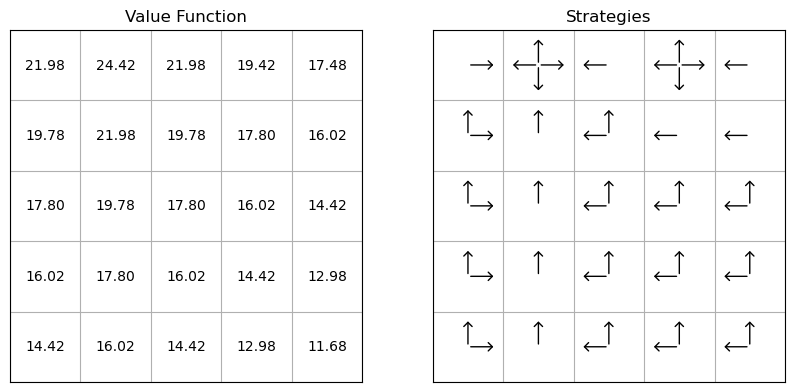

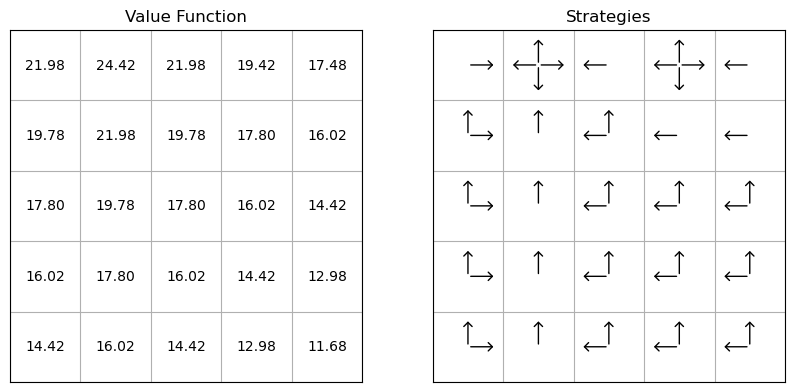

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch


class Agent:
    def __init__(self, gamma: float) -> None:
        """
        该函数初始化用于解决例3.5的智能体.
        :param gamma: 奖励的衰减率.
        """
        self.gamma = gamma
        self.reward = np.array([-1, 0, 5, 10])  # 创建奖励向量
        self.value_function = np.zeros((5, 5))  # 初始化一个全0的value_function.
        self.strategy = 0.25 * np.ones((5, 5, 4))  # 初始化一个策略，该策略表明智能体在每个格点都会有相同的概率向周围四个单元格行走.

        # 初始化动力学函数，p(s',r|s,a)，前两个维度代表新的状态，第三个维度代表reward的值，reward按照index分别是-1,0,5,10，四五维度代表原本状态，第六个维度则代表action，index从小到大分别是上下左右.
        self.dynamic_function = np.zeros(
            (5, 5, 4, 5, 5, 4))

        # 尝试移出边界会导致奖励-1
        for i in range(5):
            self.dynamic_function[0, i, 0, 0, i, 0] = 1
            self.dynamic_function[i, 4, 0, i, 4, 1] = 1
            self.dynamic_function[4, i, 0, 4, i, 2] = 1
            self.dynamic_function[i, 0, 0, i, 0, 3] = 1
        self.dynamic_function[0, 1, 0, 0, 1, 0] = 0
        self.dynamic_function[0, 3, 0, 0, 3, 0] = 0

        # (0,1)的任意移动会导致奖励+10
        self.dynamic_function[4, 1, 3, 0, 1, :] = 1
        # (0,3)的任意移动会导致奖励+5
        self.dynamic_function[2, 3, 2, 0, 3, :] = 1
        # 其余的移动都不导致任何奖励
        for i in range(1, 5):
            for j in range(5):
                self.dynamic_function[i - 1, j, 1, i, j, 0] = 1 if not (
                        ((i == 0) & (j == 1)) | ((i == 0) & (j == 3))) else 0
                self.dynamic_function[j, i, 1, j, i - 1, 1] = 1 if not (
                        ((j == 0) & (i == 2)) | ((j == 0) & (i == 4))) else 0
                self.dynamic_function[i, j, 1, i - 1, j, 2] = 1 if not (
                        ((i == 1) & (j == 1)) | ((i == 1) & (j == 3))) else 0
                self.dynamic_function[j, i - 1, 1, j, i, 3] = 1 if not (
                        ((j == 0) & (i == 1)) | ((j == 0) & (i == 3))) else 0

    def evaluate(self) -> None:
        """
        该函数根据当前的策略计算价值函数，因为整体数据很小，所以使用解张量方程的形式来进行求解（只需要求25*25阶矩阵的逆，是很小的计算量，且不损失精度）. 
        """
        gamma = self.gamma
        # 使用Einstein求和计算Bellman方程前面程算张量的值
        tensor_bellman = np.einsum("ijk,lmrijk->lmrij", self.strategy, self.dynamic_function)
        # 列出解Bellman方程需要的参量
        reward_matrix = np.einsum("lmrij,r,lm->ij", tensor_bellman, self.reward, np.ones((5, 5))).flatten()
        minus_tensor = np.zeros((5, 5, 5, 5))
        for index_reward in range(4):
            minus_tensor += tensor_bellman[:, :, index_reward, :, :]
        minus_tensor *= gamma
        minus_tensor = np.reshape(minus_tensor, (25, 25))
        eye_matrix = np.eye(25)
        # 解Bellman方程，并更新value function
        self.value_function = np.linalg.solve(eye_matrix - minus_tensor.T, reward_matrix).reshape((5, 5))

    def improve(self) -> None:
        """
        该函数用于进行策略提升.
        """
        improve_tensor = np.zeros((5, 5, 4))
        for index_reward in range(4):
            improve_tensor[:, :, index_reward] += self.reward[index_reward] * np.ones((5, 5))
            improve_tensor[:, :, index_reward] += self.gamma * self.value_function
        programing_tensor = np.einsum("lmrijk,lmr->ijk", self.dynamic_function, improve_tensor)
        # 贪心地进行优化
        max = np.max(programing_tensor, axis=2, keepdims=True)
        is_max = np.isclose(programing_tensor, max, atol=1e-6)
        counts = np.sum(is_max, axis=2, keepdims=True)
        result = np.zeros((5, 5, 4))
        counts = np.tile(counts, (1, 1, 4))
        result[is_max] = 1 / counts[is_max]
        self.strategy = result

    def visualize(self) -> None:
        """
        该函数用于网格世界的可视化
        """
        # 网格世界的大小
        grid_size = (5, 5)
        # 创建图和两个子图
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1行2列的子图布局
        # 绘制状态值
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                # 在状态值子图中添加文本
                axs[0].text(j, i, f'{self.value_function[i, j]:.2f}', ha='center', va='center', color='black')
        # 设置状态值子图的属性
        axs[0].set_xticks(np.arange(-0.5, grid_size[1], 1), [])
        axs[0].set_yticks(np.arange(-0.5, grid_size[0], 1), [])
        axs[0].grid(True)
        axs[0].set_title('Value Function')
        axs[0].set_xticklabels([])
        axs[0].set_yticklabels([])
        axs[0].set_xlim(-0.5, grid_size[1] - 0.5)
        axs[0].set_ylim(-0.5, grid_size[0] - 0.5)
        axs[0].invert_yaxis()
        axs[0].xaxis.set_ticks_position('none')
        axs[0].yaxis.set_ticks_position('none')
        axs[0].set_aspect('equal')

        for x_index in range(5):
            for y_index in range(5):
                if not np.isclose(self.strategy[x_index, y_index, 0], 0):
                    dy = 0.4
                    arrow = FancyArrowPatch((y_index, x_index), (y_index, x_index - dy),
                                            arrowstyle='->,head_width=3,head_length=3',
                                            color='black', lw=1)
                    axs[1].add_patch(arrow)
                if not np.isclose(self.strategy[x_index, y_index, 1], 0):
                    dx = 0.4
                    arrow = FancyArrowPatch((y_index, x_index), (y_index + dx, x_index),
                                            arrowstyle='->,head_width=3,head_length=3',
                                            color='black', lw=1)
                    axs[1].add_patch(arrow)
                if not np.isclose(self.strategy[x_index, y_index, 2], 0):
                    dy = 0.4
                    arrow = FancyArrowPatch((y_index, x_index), (y_index, x_index + dy),
                                            arrowstyle='->,head_width=3,head_length=3',
                                            color='black', lw=1)
                    axs[1].add_patch(arrow)
                if not np.isclose(self.strategy[x_index, y_index, 3], 0):
                    dx = 0.4
                    arrow = FancyArrowPatch((y_index, x_index), (y_index - dx, x_index),
                                            arrowstyle='->,head_width=3,head_length=3',
                                            color='black', lw=1)
                    axs[1].add_patch(arrow)

        axs[1].set_xticks(np.arange(-0.5, grid_size[1], 1), [])
        axs[1].set_yticks(np.arange(-0.5, grid_size[0], 1), [])
        axs[1].grid(True)
        axs[1].set_title('Strategies')
        axs[1].set_xticklabels([])
        axs[1].set_yticklabels([])
        axs[1].set_xlim(-0.5, grid_size[1] - 0.5)
        axs[1].set_ylim(-0.5, grid_size[0] - 0.5)
        axs[1].invert_yaxis()
        axs[1].xaxis.set_ticks_position('none')
        axs[1].yaxis.set_ticks_position('none')
        axs[1].set_aspect('equal')
        plt.show()

    def learn(self, times):
        """
        该函数使智能体开始按谁定的策略学习，同事将学习的结果可视化.
        :param times: 进行学习的轮数.
        """
        for epochs in range(times):
            self.evaluate()
            a.visualize()
            self.improve()


a = Agent(gamma=0.9)
a.learn(times=8)
        